# Decision Trees on the Wine Dataset — Overfitting, Criteria (Gini vs Entropy), and Hyperparameter Tuning

**Plan**
1. Train two default trees (`criterion='gini'` vs `criterion='entropy'`) and compare performance and feature importances.  
2. Analyse overfitting using accuracy and classification metrics (precision, recall, f1 score, confusion matrix, etc.).
3. Visualise and compare the trees learnt using the two splitting criteria.
4. Perform hyperparameter tuning with cross-validation to find the best values for: max_depth", "min_samples_split", and "min_samples_leaf".
5. Reflect on the analysis through the questions at the end of the notebook.

## Setup

In [2]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(42)

## Load and Explore dataset

In [10]:
data = load_wine()
X, y = data.data, data.target
feature_names = data.feature_names
target_names = data.target_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
display(df.head())
print("Shape:", X.shape, "| Classes:", target_names)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


Shape: (178, 13) | Classes: ['class_0' 'class_1' 'class_2']


## Train/Test Split (Stratified)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_train.shape, X_test.shape

((124, 13), (54, 13))

## Unconstrained Comparison: Gini vs Entropy (No Tuning)

In [12]:
models = {
    'gini': DecisionTreeClassifier(criterion='gini', random_state=42),
    'entropy': DecisionTreeClassifier(criterion='entropy', random_state=42)
}

perf = {}
for name, clf in models.items():
    clf.fit(X_train, y_train)
    perf[name] = {
        'train_acc': clf.score(X_train, y_train),
        'test_acc':  clf.score(X_test, y_test),
        'model': clf
    }

print("Unconstrained performance")
for name, d in perf.items():
    print(f"{name.capitalize():<7} | Train: {d['train_acc']:.3f} | Test: {d['test_acc']:.3f}")

Unconstrained performance
Gini    | Train: 1.000 | Test: 0.963
Entropy | Train: 1.000 | Test: 0.907


<details>
<summary><strong>Solution notes (Part 1)</strong></summary>

- Both criteria usually reach **high test accuracy** on the wine dataset (often > 0.9).  
- The **structures** of the Gini and Entropy trees are not that similar.
- Since training accuracy ≈ 1.0 and test accuracy is lower, the trees **overfit**.

</details>

### Classification Reports (Test Set)

In [13]:
for name, d in perf.items():
    print(f"\n----- {name.upper()} -----")
    print(classification_report(y_test, d['model'].predict(X_test), target_names=target_names))


----- GINI -----
              precision    recall  f1-score   support

     class_0       1.00      0.94      0.97        18
     class_1       0.91      1.00      0.95        21
     class_2       1.00      0.93      0.97        15

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.97      0.96      0.96        54


----- ENTROPY -----
              precision    recall  f1-score   support

     class_0       0.94      0.89      0.91        18
     class_1       0.90      0.86      0.88        21
     class_2       0.88      1.00      0.94        15

    accuracy                           0.91        54
   macro avg       0.91      0.92      0.91        54
weighted avg       0.91      0.91      0.91        54



### Visualise the Unconstrained Trees

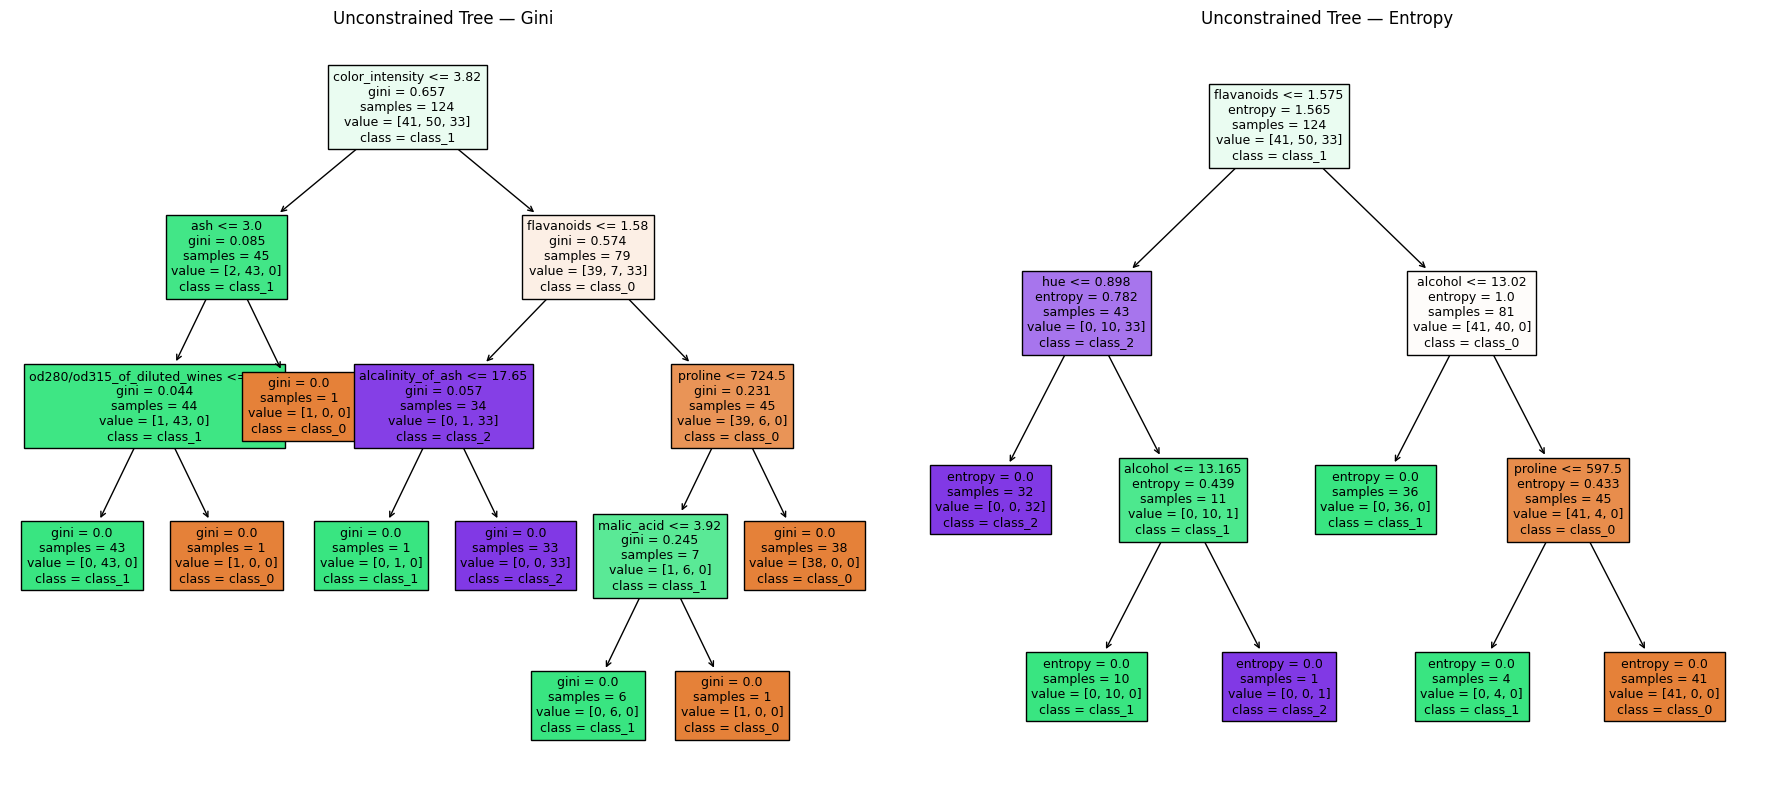

In [7]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plot_tree(perf['gini']['model'], filled=True, feature_names=feature_names, class_names=target_names, fontsize=9)
plt.title("Unconstrained Tree — Gini")

plt.subplot(1, 2, 2)
plot_tree(perf['entropy']['model'], filled=True, feature_names=feature_names, class_names=target_names, fontsize=9)
plt.title("Unconstrained Tree — Entropy")
plt.tight_layout()
plt.show()

### Feature Importances (Unconstrained Trees)

,feature,gini_importance,entropy_importance
6,flavanoids,0.404915,0.409101
9,color_intensity,0.396761,0.000000
12,proline,0.106573,0.100379
11,od280/od315_of_diluted_wines,0.023982,0.000000
3,alcalinity_of_ash,0.023818,0.000000
2,ash,0.022916,0.000000
1,malic_acid,0.021034,0.000000
0,alcohol,0.000000,0.342015
4,magnesium,0.000000,0.000000
5,total_phenols,0.000000,0.000000


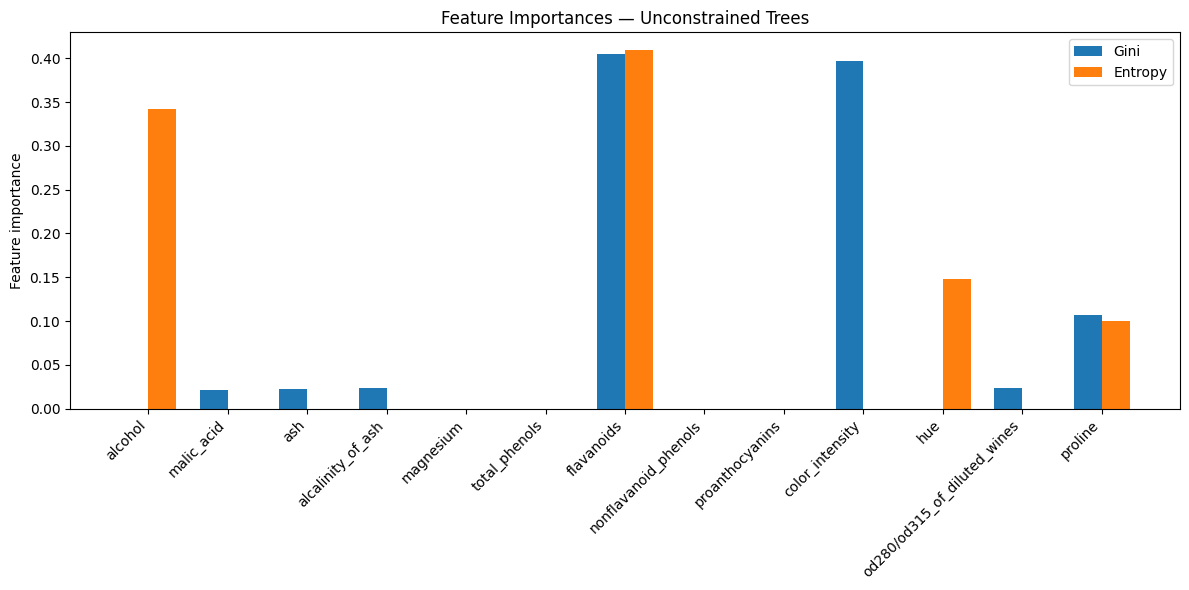

In [9]:
gini_imp = perf['gini']['model'].feature_importances_
entr_imp = perf['entropy']['model'].feature_importances_

imp_df_unconstrained = pd.DataFrame({
    'feature': feature_names,
    'gini_importance': gini_imp,
    'entropy_importance': entr_imp
}).sort_values('gini_importance', ascending=False)

display(imp_df_unconstrained)

indices = np.arange(len(feature_names))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(indices - width/2, gini_imp, width, label='Gini')
plt.bar(indices + width/2, entr_imp, width, label='Entropy')
plt.xticks(indices, feature_names, rotation=45, ha='right')
plt.ylabel("Feature importance")
plt.title("Feature Importances — Unconstrained Trees")
plt.legend()
plt.tight_layout()
plt.show()

### Technical note on feature importance (for those interested)


A Decision Tree Classifier measures **feature importance** by evaluating how much each feature contributes to reducing the overall impurity in the tree.

Every time the tree splits a node using a feature, it computes how much that split reduces impurity (e.g., Gini impurity or entropy):

$$
\Delta I = I_{\text{parent}} - \frac{n_L}{n} I_{\text{left}} - \frac{n_R}{n} I_{\text{right}}
$$

where:
- $ I_{\text{parent}} $: impurity of the parent node  
- $ I_{\text{left}}, I_{\text{right}} $: impurities of the left and right child nodes  
- $ n_L, n_R $: number of samples in each child node  
- $ n = n_L + n_R $: total samples in the parent node  

This quantity $\Delta I$ is called the **impurity decrease** (or **information gain**).

For each feature $j$, the tree sums up the impurity decreases $\Delta I$  for all nodes where that feature was used to split:

$$
\text{Importance}(j) = \sum_{\text{nodes using } j} \frac{n_{\text{node}}}{n_{\text{total}}} \, \Delta I_{\text{node}}
$$

Each decrease is **weighted** by the proportion of samples that reached that node,  
so splits higher in the tree (affecting many samples) contribute more to the feature’s importance.

Finally, all importances are normalised to sum to 1:

$$
\tilde{I}(j) = \frac{\text{Importance}(j)}{\sum_k \text{Importance}(k)}
$$

These normalised values are what you see in:

```python
tree.feature_importances_




**Observation:** If training accuracy ≈ 1.0 and test accuracy is lower, the tree likely **overfits**.  
We now mitigate this with **pre-pruning** and cross-validation.

## Pre-Pruning: Manual Sweep of `max_depth` (Gini default)

In [8]:
depths = [2, 3, 4, 5, 6, 8, None]
print("Depth | Train Acc | Test Acc")
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, random_state=42)
    clf.fit(X_train, y_train)
    print(f"{str(d):>5} |   {clf.score(X_train, y_train):.3f}   |  {clf.score(X_test, y_test):.3f}")

Depth | Train Acc | Test Acc
    2 |   0.935   |  0.889
    3 |   0.992   |  0.963
    4 |   1.000   |  0.963
    5 |   1.000   |  0.963
    6 |   1.000   |  0.963
    8 |   1.000   |  0.963
 None |   1.000   |  0.963


## Hyperparameter Tuning with Cross-Validation (Pre-Pruning)

In [9]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

best_models_tuned = {}
for crit in ['gini', 'entropy']:
    grid = GridSearchCV(
        DecisionTreeClassifier(random_state=42, criterion=crit),
        param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_models_tuned[crit] = grid.best_estimator_
    print(f"[{crit.upper()}] Best params: {grid.best_params_} | Best CV acc: {grid.best_score_:.3f}")

[GINI] Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5} | Best CV acc: 0.878
[ENTROPY] Best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5} | Best CV acc: 0.886


### Evaluate Tuned Models

In [10]:
for crit, model in best_models_tuned.items():
    tr = model.score(X_train, y_train)
    te = model.score(X_test, y_test)
    print(f"{crit.capitalize():<7} | Train: {tr:.3f} | Test: {te:.3f}")

Gini    | Train: 0.992 | Test: 0.963
Entropy | Train: 1.000 | Test: 0.907


### Feature Importances — Tuned Trees

,feature,gini_importance,entropy_importance
6,flavanoids,0.413615,0.409101
9,color_intensity,0.405286,0.000000
12,proline,0.108863,0.100379
11,od280/od315_of_diluted_wines,0.024497,0.000000
3,alcalinity_of_ash,0.024330,0.000000
2,ash,0.023409,0.000000
0,alcohol,0.000000,0.342015
1,malic_acid,0.000000,0.000000
4,magnesium,0.000000,0.000000
5,total_phenols,0.000000,0.000000


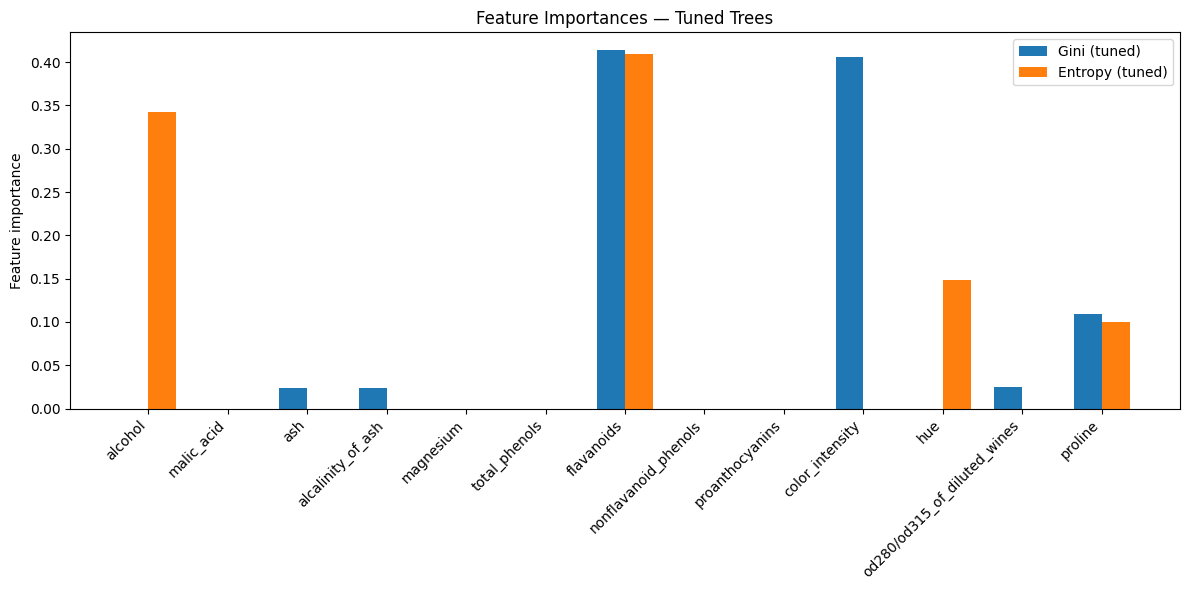

In [11]:
imp_df_tuned = pd.DataFrame({
    'feature': feature_names,
    'gini_importance': best_models_tuned['gini'].feature_importances_,
    'entropy_importance': best_models_tuned['entropy'].feature_importances_
}).sort_values('gini_importance', ascending=False)

display(imp_df_tuned)

indices = np.arange(len(feature_names))
width = 0.35
plt.figure(figsize=(12,6))
plt.bar(indices - width/2, best_models_tuned['gini'].feature_importances_, width, label='Gini (tuned)')
plt.bar(indices + width/2, best_models_tuned['entropy'].feature_importances_, width, label='Entropy (tuned)')
plt.xticks(indices, feature_names, rotation=45, ha='right')
plt.ylabel("Feature importance")
plt.title("Feature Importances — Tuned Trees")
plt.legend()
plt.tight_layout()
plt.show()

## Reflection
1. Which criterion performed better without tuning? Did feature importances differ?  
2. After tuning, how did the generalisation gap change for each criterion?  
3. Which hyperparameters had the biggest effect (depth vs leaf size vs min split)?  